In [12]:
#pip install xgboost
#!pip install dtreeviz
#!pip install optuna
#!pip install tensorflow

   ---------------------------------------- 0.0/377.0 MB ? eta -:--:--
   ---------------------------------------- 0.2/377.0 MB 3.6 MB/s eta 0:01:46
   ---------------------------------------- 0.5/377.0 MB 5.3 MB/s eta 0:01:12
   ---------------------------------------- 0.8/377.0 MB 5.9 MB/s eta 0:01:04
   ---------------------------------------- 1.0/377.0 MB 6.0 MB/s eta 0:01:03
   ---------------------------------------- 1.3/377.0 MB 5.6 MB/s eta 0:01:08
   ---------------------------------------- 1.5/377.0 MB 5.4 MB/s eta 0:01:10
   ---------------------------------------- 1.9/377.0 MB 5.7 MB/s eta 0:01:06
   ---------------------------------------- 2.2/377.0 MB 5.9 MB/s eta 0:01:04
   ---------------------------------------- 2.6/377.0 MB 6.1 MB/s eta 0:01:02
   ---------------------------------------- 2.9/377.0 MB 6.2 MB/s eta 0:01:01
   ---------------------------------------- 3.3/377.0 MB 6.3 MB/s eta 0:01:00
   ---------------------------------------- 3.6/377.0 MB 6.4 MB/s eta 0

In [13]:
# Genearal usage
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import scipy.stats as stats
import copy
import itertools
import math
import warnings

# Linear models
from sklearn import linear_model
from statsmodels.formula.api import ols

# model preparation and evaluation
from sklearn.model_selection import test_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold

# XGBoost
import xgboost as xgb
from dtreeviz.trees import *
from sklearn import model_selection
import optuna

# LSTM
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

#Ensemble
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

<img src="raw/bikeProblem.png" width="600" height="500">

Load test and test data (See Bike_EDA_PreProcessing.ipynb for details)

In [14]:
X_train = pd.read_excel('raw/X_train.xlsx')
y_train = pd.read_excel('raw/y_train.xlsx')
X_train_c = pd.read_excel('raw/X_train_c.xlsx')
y_train_c = pd.read_excel('raw/y_train_c.xlsx')
X_train_r = pd.read_excel('raw/X_train_r.xlsx')
y_train_r = pd.read_excel('raw/y_train_r.xlsx')

X_test = pd.read_excel('raw/X_test.xlsx')
y_test = pd.read_excel('raw/y_test.xlsx')
X_test_c = pd.read_excel('raw/X_test_c.xlsx')
y_test_c = pd.read_excel('raw/y_test_c.xlsx')
X_test_r = pd.read_excel('raw/X_test_r.xlsx')
y_test_r = pd.read_excel('raw/y_test_r.xlsx')

<hr style="border-top: 0.5px solid #b;">
<b style="font-size: 22px;">Task1</b> <h style="font-size: 18px;"> : Develop at least two different models and train them on the training set. Find a proper way to combine prediction results of these model. </h>
<hr style="border-top: 0.5px solid #b;">

##### 1) XGBoost

Training Steps:
['temp', 'hum', 'weathersit', 'workingday', 'season', 'yr', 'hr']
1. Predict 'casual' using ['temp', 'hum', 'weathersit', 'workingday', 'yr', 'hr']
2. Predict 'register' using ['temp', 'hum', 'season', 'yr', 'hr']
3. Add 1. 2. together to derive the predicted 'cnt'
4. Predict 'cnt' using  ['temp', 'hum', 'hr', 'yr', 'season'] to ensemble with the other model and to assess the performance comparison to the model generated in 3..

1.1) Predict 'casual'

In [15]:
# reduce the feature to the selected ones.
X_train_c = X_train_c[['temp', 'hum', 'weathersit', 'workingday', 'yr', 'hr']]
X_test_c = X_test_c[['temp', 'hum', 'weathersit', 'workingday', 'yr', 'hr']]

In [22]:
y_train_c.set_index('datetime', inplace = True)
y_test_c.set_index('datetime', inplace = True)

KeyError: "None of ['datetime'] are in the columns"

In [29]:
model_xgb_c = xgb.XGBRegressor()

def objective(trial):
    
    #hyperparameter searching
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0)
    }
    model_xgb_c.set_params(**params)
    #CV config
    score = model_selection.cross_val_score(model_xgb_c,
                                            X_train_c,
                                            y_train_c,
                                            n_jobs=-1,
                                            cv=10,
                                            scoring = 'neg_mean_squared_error'
                                           )
    val = - score.mean()
    return val

In [30]:
# Searching for the optimal hyperparameter
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)
print(f"The best parameters are : \n {study.best_params}")

[I 2024-03-16 21:01:37,451] A new study created in memory with name: no-name-b65a9387-03a8-45f5-a1f9-5cc5409d4d4c
C:\Users\Ryo\AppData\Local\Temp\ipykernel_12724\753032069.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-03-16 21:01:47,285] Trial 0 finished with value: 630.1616786513227 and parameters: {'max_depth': 9, 'n_estimators': 401, 'learning_rate': 0.2702222680085647}. Best is trial 0 with value: 630.1616786513227.
[I 2024-03-16 21:01:48,579] Trial 1 finished with value: 1819.177949290782 and parameters: {'max_depth': 6, 'n_estimators': 308, 'learning_rate': 0.0005256701251965219}. Best is trial 0 with value: 630.1616786513227.
[I 2024-03-16 21:01:52,676] Trial 2 finished with value: 1539.1938799419522 and parameters: {'max_depth': 6, 'n_estimators': 815, 'learning_rate': 0.00035339833845812307}. Best is trial 

The best parameters are : 
 {'max_depth': 6, 'n_estimators': 366, 'learning_rate': 0.010921369749533833}


In [31]:
model_xgb_c = xgb.XGBRegressor(**study.best_params)
model_xgb_c.fit(X_train_c.values, y_train_c.values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.010921369749533833,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=366, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [32]:
importance = pd.DataFrame(zip(X_train_c.columns,
                              model_xgb_c.feature_importances_),
                              columns=["Features","Importance"])
importance = importance.sort_values("Importance",
                                    ascending=False)
importance

,Features,Importance
3,workingday,0.385979
5,hr,0.259702
0,temp,0.174992
4,yr,0.115529
1,hum,0.040662
2,weathersit,0.023136


<Axes: xlabel='Features'>

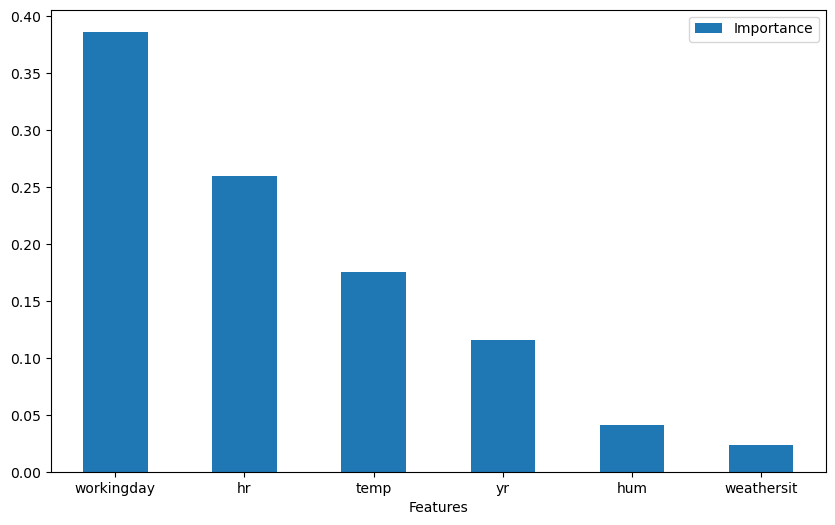

In [33]:
importance.plot.bar(x = 'Features',
                    y = 'Importance', 
                    rot=0, figsize=(10, 6))

In [53]:
# prediction
train_pred_c = model_xgb_c.predict(X_train_c.values)
test_pred_c = model_xgb_c.predict(X_test_c.values)

# predicted result
train_MAPE_xgb_c = mean_absolute_percentage_error(y_train_c, train_pred_c)
test_MAPE_xgb_c = mean_absolute_percentage_error(y_test_c, test_pred_c)

print('train MAPE: ', train_MAPE_xgb_c)
print('test MAPE: ', test_MAPE_xgb_c)

train MAPE:  1067167848669788.2
test MAPE:  874009019849056.1


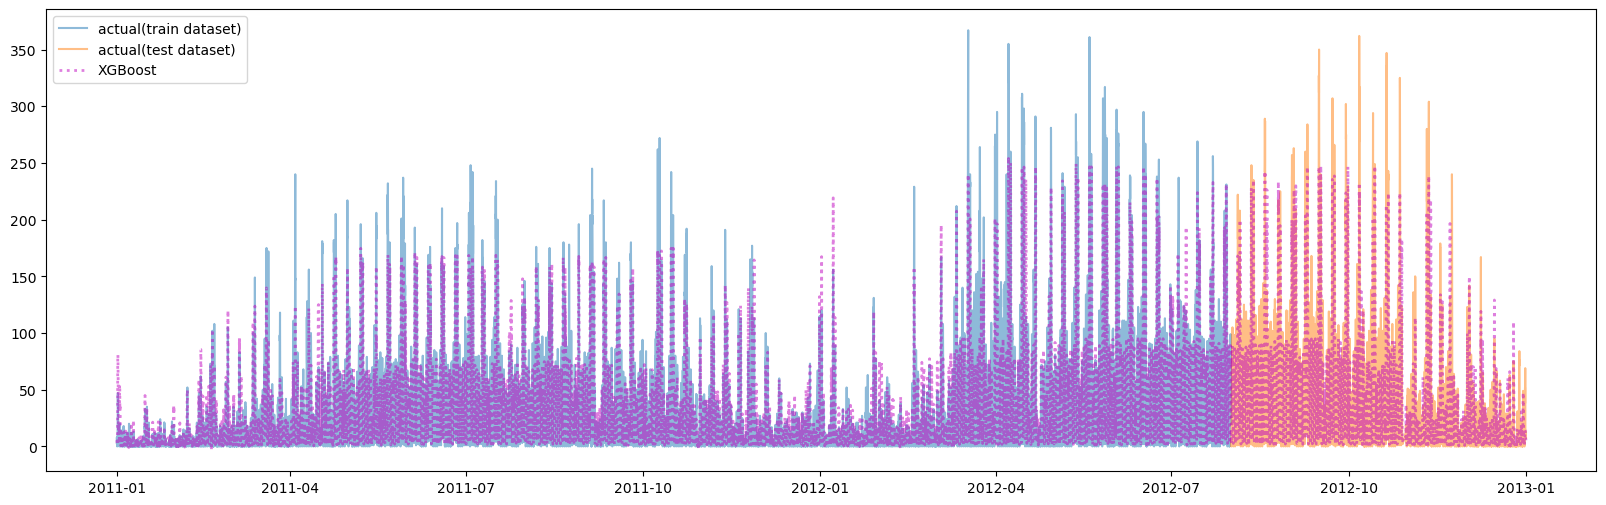

In [38]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y_train_c.index, y_train_c.values, label="actual(train dataset)", alpha = 0.5)
ax.plot(y_test_c.index, y_test_c.values, label="actual(test dataset)", alpha = 0.5)
ax.plot(y_train_c.index, train_pred_c, linestyle="dotted", lw=2,color="m", alpha = 0.5)
ax.plot(y_test_c.index, test_pred_c, label="XGBoost", linestyle="dotted", lw=2, color="m", alpha = 0.5) 
plt.legend()

In [41]:
y_test_c.head()

,casual
datetime,
2012-08-01 00:00:00,3
2012-08-01 01:00:00,5
2012-08-01 02:00:00,0
2012-08-01 03:00:00,0
2012-08-01 04:00:00,1


In [54]:
xgb_result_c = pd.DataFrame({'actual' : y_test_c.values.flatten(),
                              'pred' : test_pred_c.flatten()})
print(xgb_result_c.describe())

            actual         pred
count  3632.000000  3632.000000
mean     42.887390    40.872421
std      55.980942    50.650043
min       0.000000     0.501923
25%       5.000000     6.459895
50%      22.000000    20.920827
75%      61.000000    60.119908
max     362.000000   247.328522


1.2) Predict 'registered'

<hr style="border-top: 0.5px solid #b;">
<b style="font-size: 22px;">Task2</b> <h style="font-size: 18px;">  : Explore the data through descriptive statistics and visualization and summarize your findings about the data. </h>
<hr style="border-top: 0.5px solid #b;">

In [19]:
bike.describe()

,season,yr,mnth,dy,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.502561,6.537775,15.683411,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,1.106918,0.500008,3.438776,8.789373,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,4.000000,8.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,3.000000,1.000000,7.000000,16.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,3.000000,1.000000,10.000000,23.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,4.000000,1.000000,12.000000,31.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


On average, 20% of usage comes from casual users and 80% comes from registered users.

##### 1) Time series analysis for the dependent variable ('cnt')

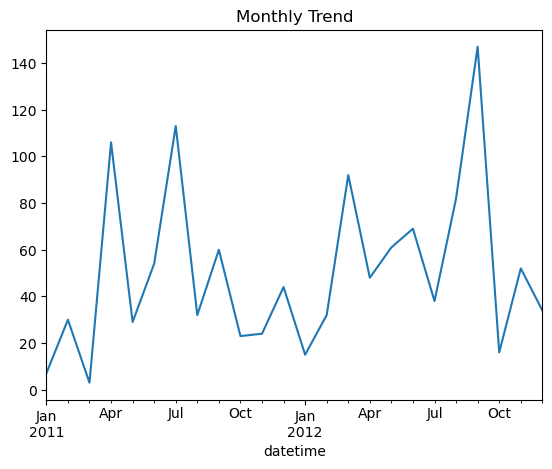

In [20]:
bike['cnt'].asfreq('M').plot() 
plt.title('Monthly Trend')
plt.show()

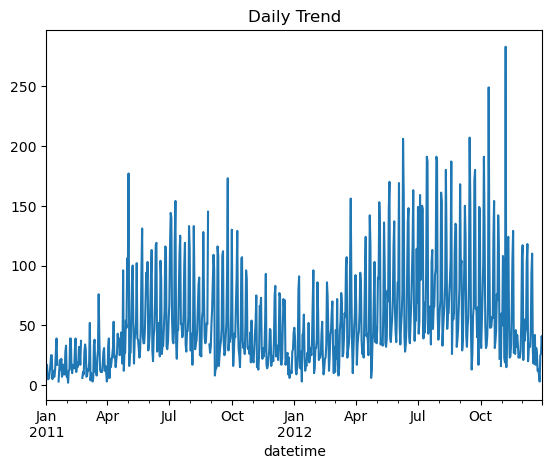

In [21]:
bike['cnt'].asfreq('D').plot() 
plt.title('Daily Trend')
plt.show()

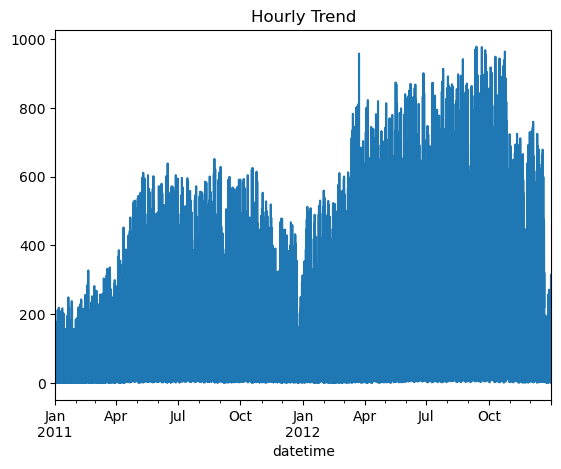

In [22]:
bike['cnt'].asfreq('H').plot() 
plt.title('Hourly Trend')
plt.show()

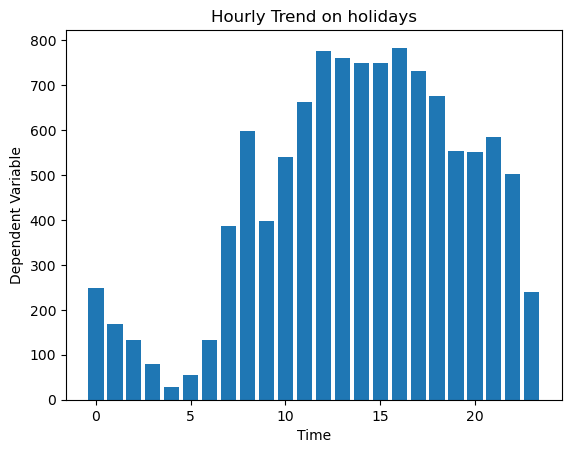

In [23]:
plt.bar(bike[bike['workingday'] == 0]['hr'], bike[bike['workingday'] == 0]['cnt'])
plt.xlabel('Time')
plt.ylabel('Dependent Variable')
plt.title('Hourly Trend on holidays')
plt.show()

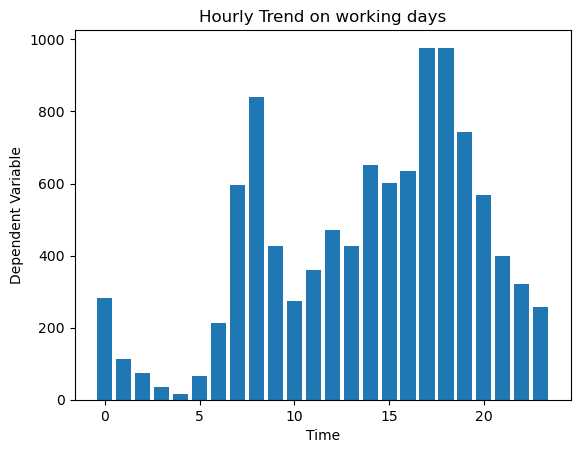

In [24]:
plt.bar(bike[bike['workingday'] == 1]['hr'], bike[bike['workingday'] == 1]['cnt'])
plt.xlabel('Time')
plt.ylabel('Dependent Variable')
plt.title('Hourly Trend on working days')
plt.show()

In [25]:
holiday_cnt = bike[bike['workingday'] == 0]['cnt'].sum()
workday_cnt = bike[bike['workingday'] == 1]['cnt'].sum()
print('total cnt on holiday is {}. total cnt on workingdays is {}' .format(holiday_cnt, workday_cnt))

total cnt on holiday is 1000269. total cnt on workingdays is 2292410


- People tend to use bike on workingdays twice more than on holiday
- For both of holiday and working days, people tend not to use bikes between 11pm and 6am.
- For holiday, there are consistent high usage between 8am to 10pm.
- For working days in contrast, there are peaks around 7-8am and 5-6pm and typically lower usege between 9am to 4pm.

##### 2) Check for stationarity of the 'cnt' column (Dependent Variable)

In [26]:
#ADF-test(Original-time-series)
adf = sm.tsa.adfuller(bike['cnt'].dropna(),regression='ct')
kpss = sm.tsa.kpss(bike['cnt'].dropna(),regression='ct')

print('ADF test p-value:{}'.format(adf[1]))
print('KPSS test p-value:{}'.format(kpss[1]))

NameError: name 'sm' is not defined

Try differenciating by 1 given the result of KPSS test suggests non-stationary.

In [ ]:
#ADF-test(Original-time-series)
adf = sm.tsa.adfuller(bike['cnt'].diff().dropna(),regression='ct')
kpss = sm.tsa.kpss(bike['cnt'].diff().dropna(),regression='ct')

print('ADF test p-value:{}'.format(adf[1]))
print('KPSS test p-value:{}'.format(kpss[1]))

ADF test p-value:0.0
KPSS test p-value:0.1


C:\Users\Ryo\AppData\Local\Temp\ipykernel_14788\4141550088.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss = sm.tsa.kpss(bike['cnt'].diff().dropna(),regression='ct')


The stationarity of the data is checked given the time series nature of the dataset.<br>
ADF test result suggests the data is highly likely to be stationary but the KPSS test strongly suggests the opposite.<br>
It is safe to consider the data is non-stationary.  It seems differenciating by 1 would pass both test. <br>
When using ARIMA or SARIMAX model, the differenciating will be implemented.

##### 3) Check for seasonality of the 'cnt' column (Dependent Variable)

Monthly trend

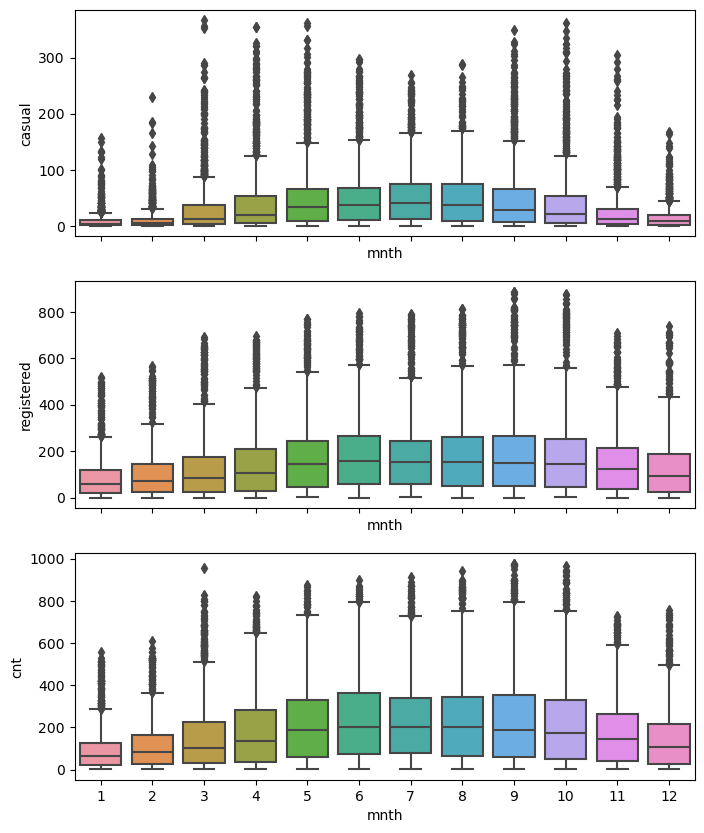

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
for name, ax in zip(['casual', 'registered', 'cnt'], axes):
    sns.boxplot(data = bike, x= bike['mnth'], y=name, ax=ax)

Day of week trend

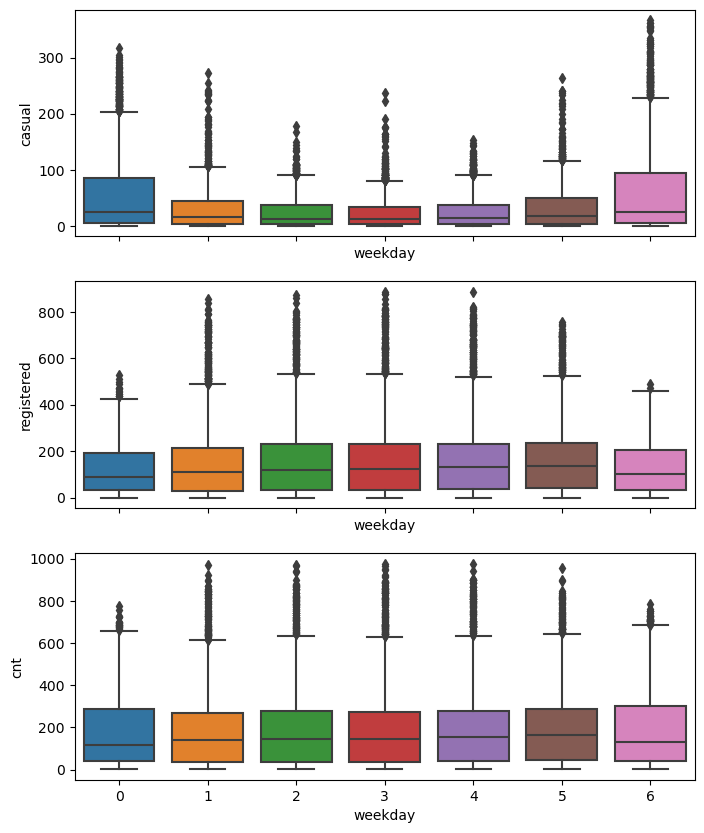

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
for name, ax in zip(['casual', 'registered', 'cnt'], axes):
    sns.boxplot(data = bike, x= bike['weekday'], y=name, ax=ax)

Hourly trend

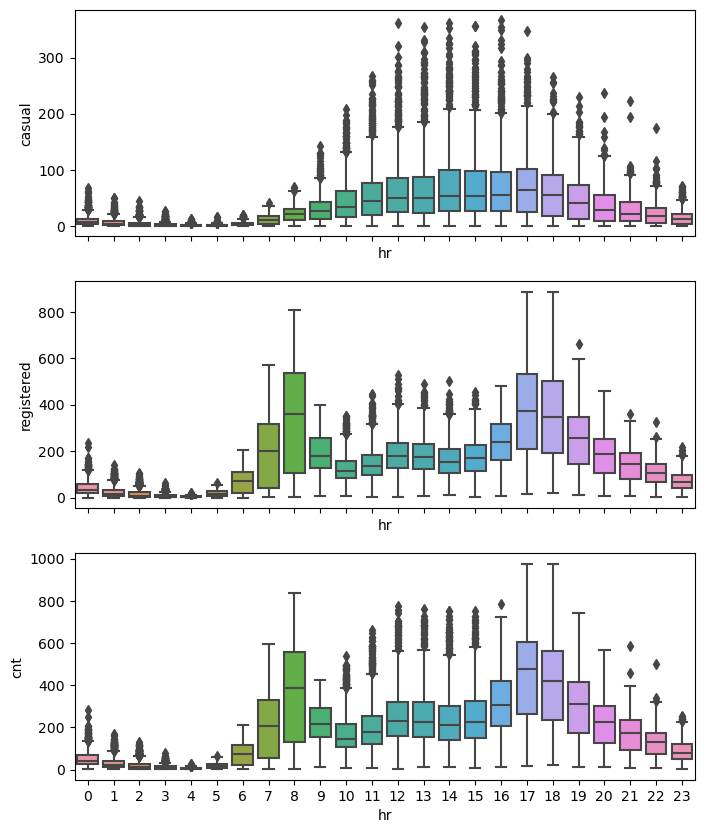

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
for name, ax in zip(['casual', 'registered', 'cnt'], axes):
    sns.boxplot(data = bike, x= bike['hr'], y=name, ax=ax)

The following seasonality can be observed:
- Month: Increased 'cnt' from between the month 5 to 9.
- Week: 'cnt' stays consistant where 'casual' users prefers more of the week end, and the 'registered' users the opposite.
- Hour: For 'cnt' and 'registered', there are peaks around 7-8am and 5-6pm and typically lower usege between 9am to 4pm. <br> For 'casual', there are consistent high usage between 8am to 10pm.

Based on this, I assume this data yields monthly and hourly seasonality.  <br>Below, the seasonal decomposition is conducted to visually comfirm the assumption.

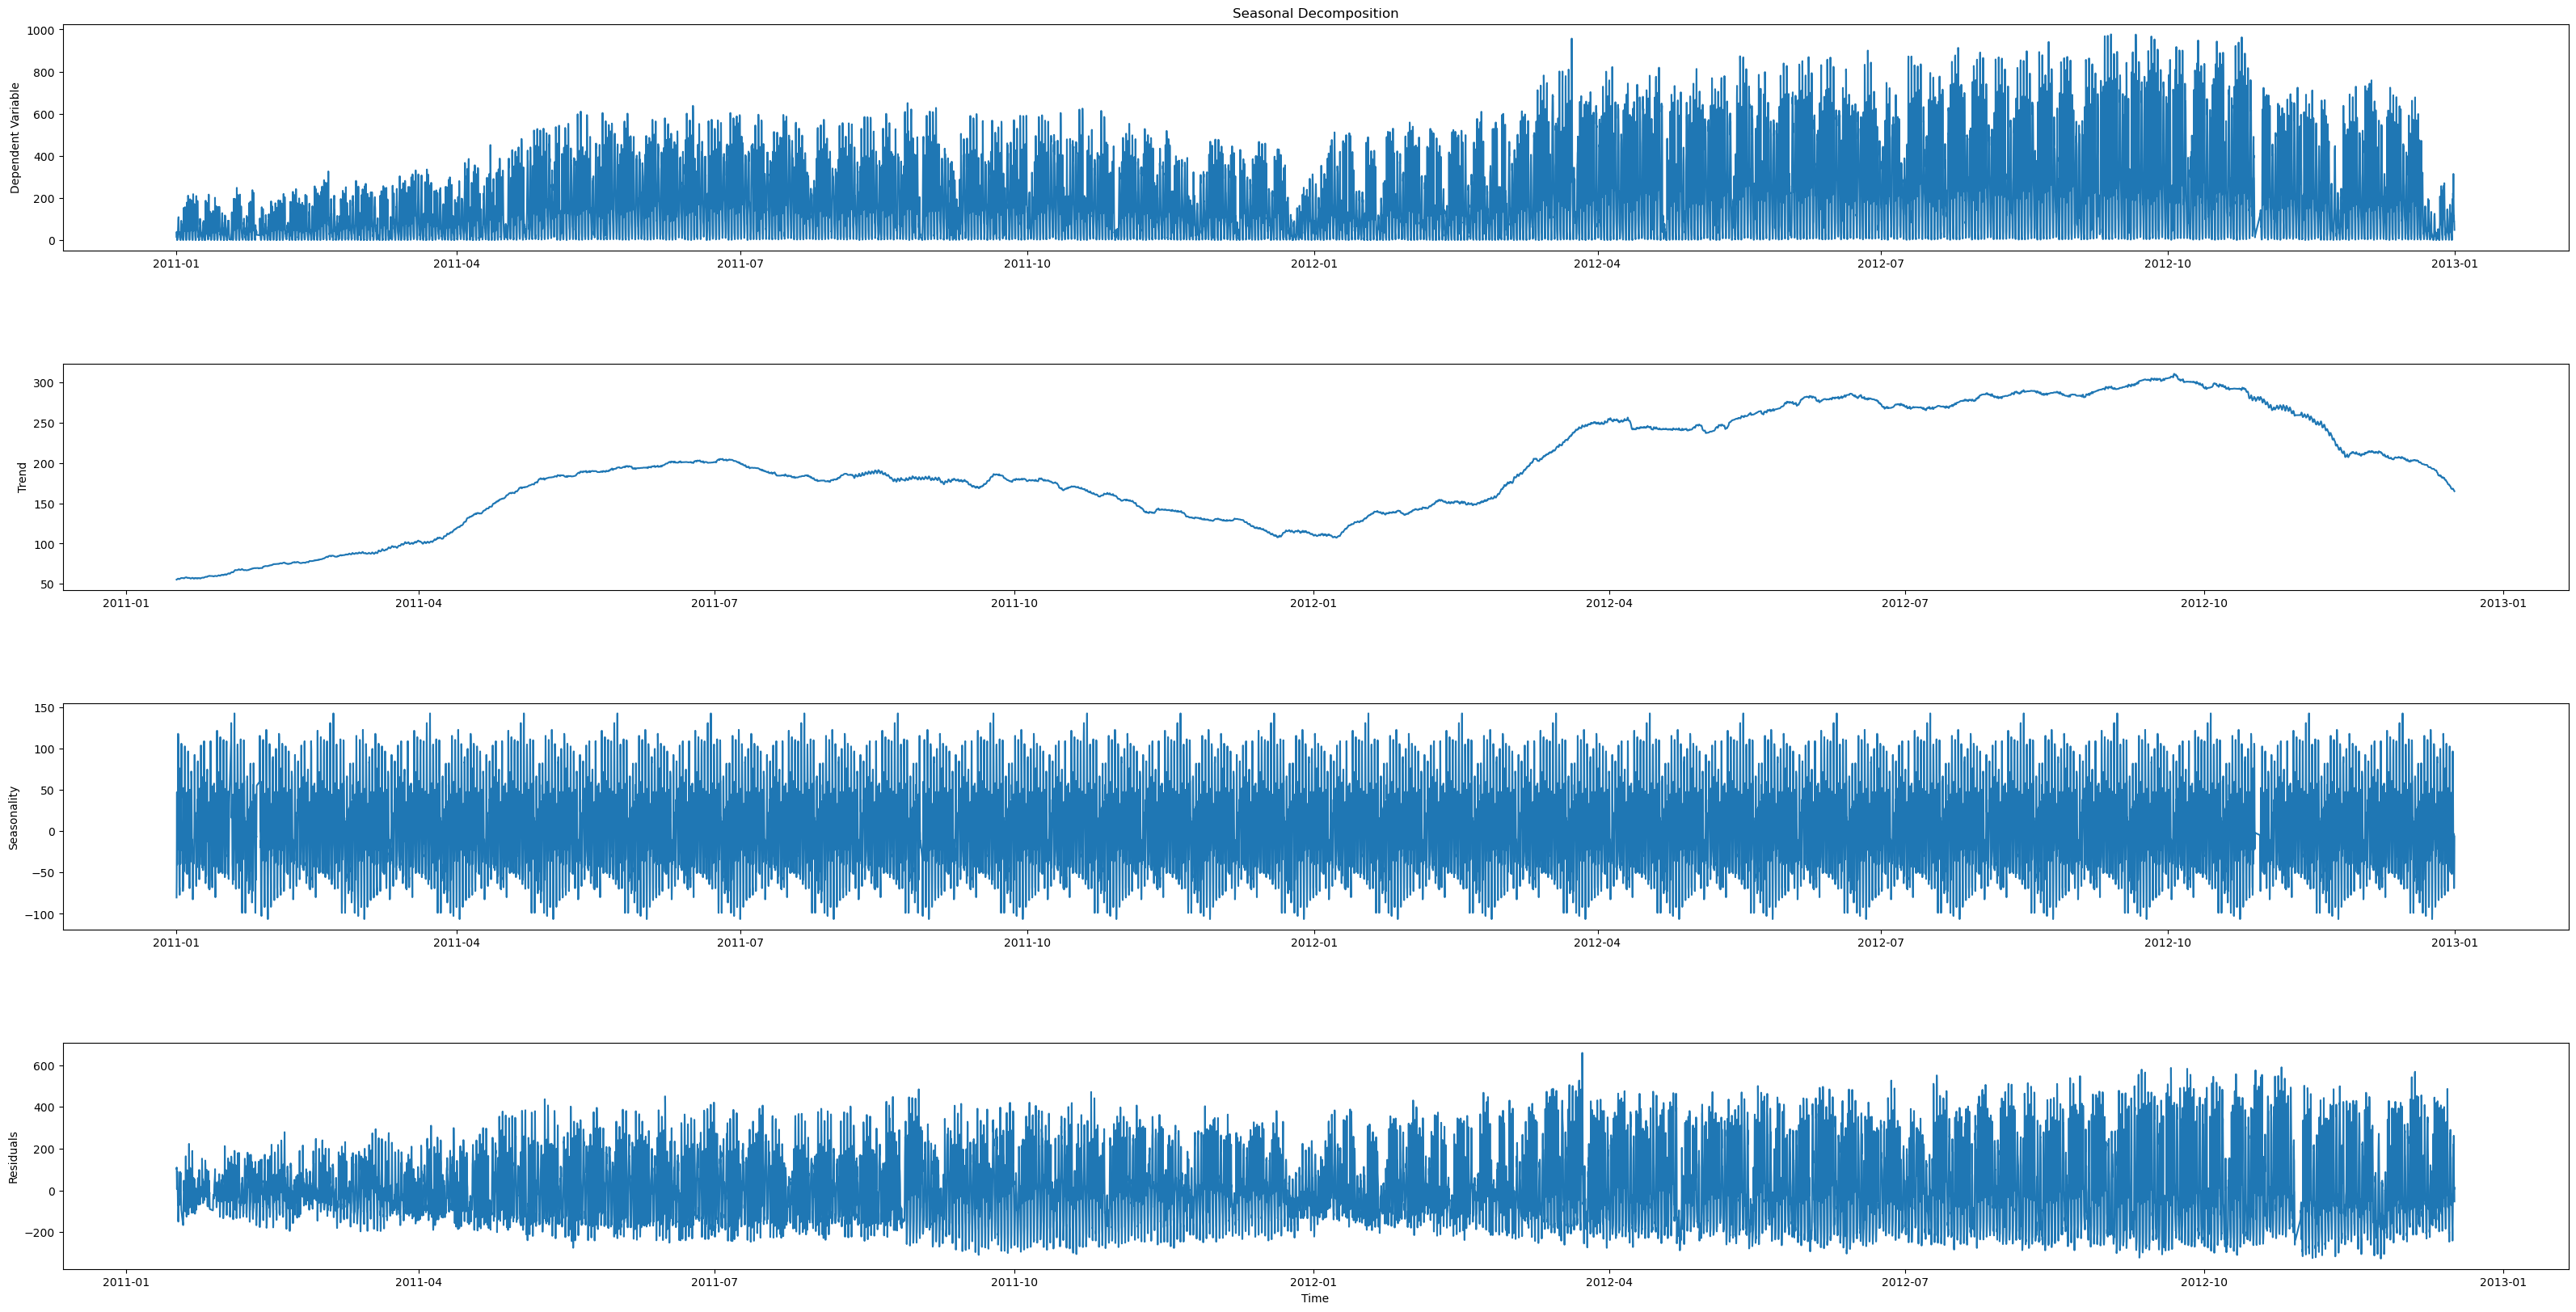

In [ ]:
# Perform seasonal decomposition for monthly seasonality (24 * 30 indicates month.)
decomposition = seasonal_decompose(bike['cnt'], model='additive', period = 24*30)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(40, 20))

# the original
ax1.plot(bike.index, bike['cnt'], label='Original')
ax1.set_ylabel('Dependent Variable')
ax1.set_title('Seasonal Decomposition')

# the trend
ax2.plot(decomposition.trend.index, decomposition.trend, label='Trend')
ax2.set_ylabel('Trend')

# the seasonal
ax3.plot(decomposition.seasonal.index, decomposition.seasonal, label='Seasonality')
ax3.set_ylabel('Seasonality')

# the residual
ax4.plot(decomposition.resid.index, decomposition.resid, label='Residuals')
ax4.set_ylabel('Residuals')
ax4.set_xlabel('Time')


plt.subplots_adjust(hspace=0.5)
handles, labels = ax1.get_legend_handles_labels()

plt.show()

Focusing only on August 2011 to view trends more clearly

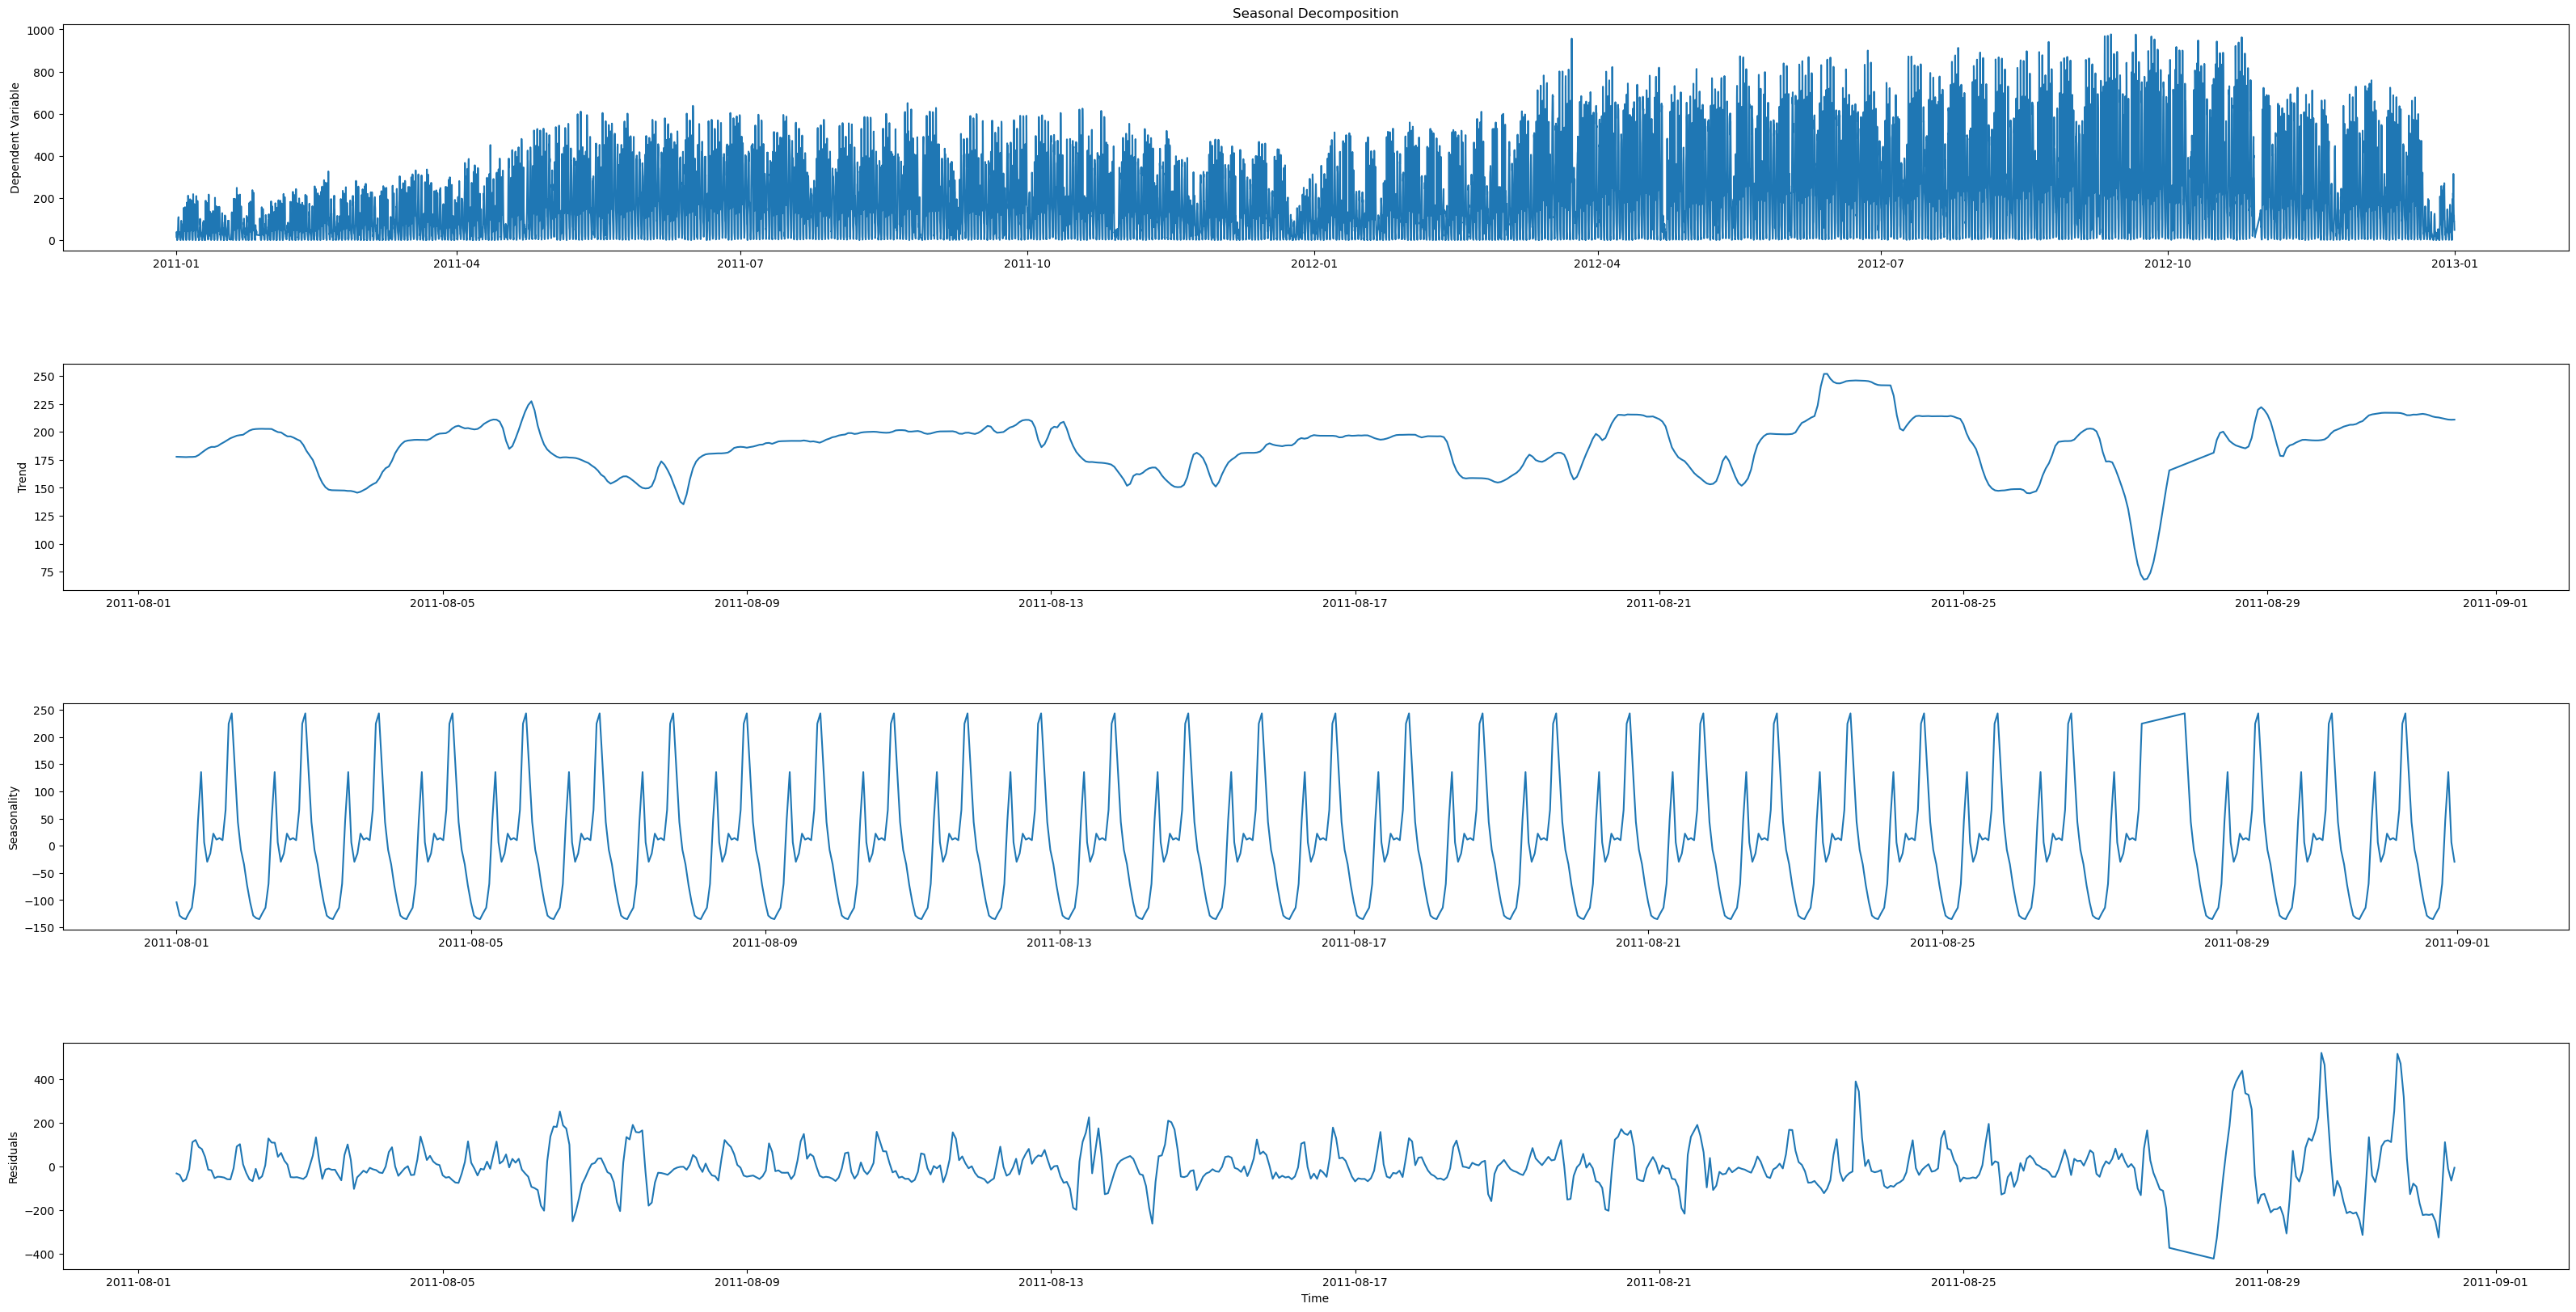

In [ ]:
# Perform seasonal decomposition for hourly seasonality (just picked 2011-08 as a sample to clearly see the ups and downs visually)
decomposition = seasonal_decompose(bike[(bike['yr'] == 0) & (bike['mnth'] == 8)]['cnt'], model='additive', period = 24)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(40, 20))

# the original
ax1.plot(bike.index, bike['cnt'], label='Original')
ax1.set_ylabel('Dependent Variable')
ax1.set_title('Seasonal Decomposition')

# the trend
ax2.plot(decomposition.trend.index, decomposition.trend, label='Trend')
ax2.set_ylabel('Trend')

# the seasonal
ax3.plot(decomposition.seasonal.index, decomposition.seasonal, label='Seasonality')
ax3.set_ylabel('Seasonality')

# the residual
ax4.plot(decomposition.resid.index, decomposition.resid, label='Residuals')
ax4.set_ylabel('Residuals')
ax4.set_xlabel('Time')


plt.subplots_adjust(hspace=0.5)
handles, labels = ax1.get_legend_handles_labels()

plt.show()

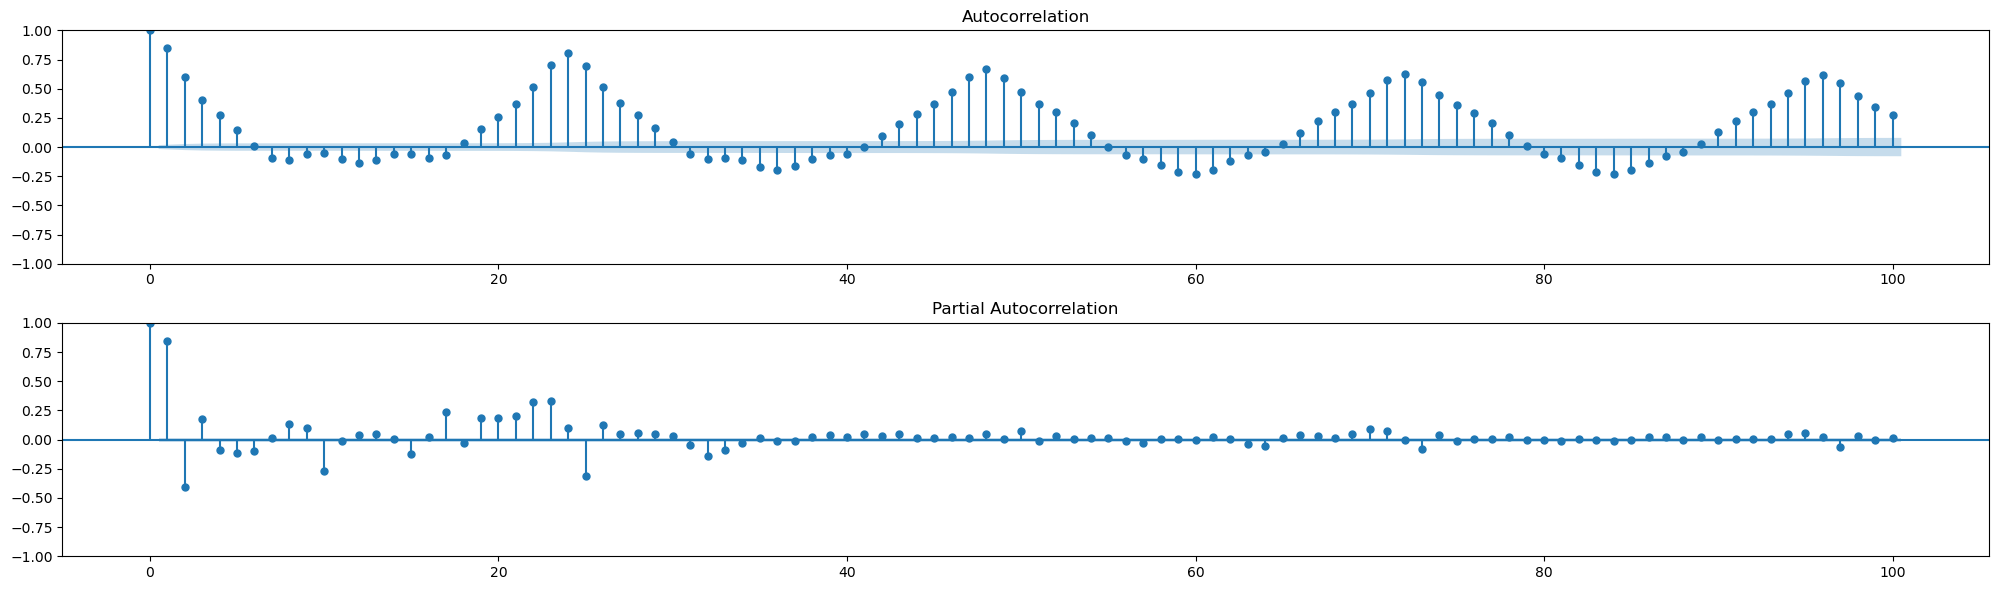

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20,6))
plot_acf(y_train, lags = 100, ax = ax[0])
plot_pacf(y_train, lags = 100, ax=ax[1])
plt.tight_layout()
plt.show()

- From the two seasonaly decomposition charts, the existance of the monthly and houlry seasonality is re-confirmed.
- ACF and PCAF further revealed that the data is autocorrelated approximately every 24 hours.

##### 4) Analysis on independent variables

In [ ]:
# Correlation matrix
correlation = bike.corr()

# Exclude any cell with correlation under 0.15
correlation[abs(correlation) > 0.15]

,season,yr,mnth,dy,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
season,1.000000,NaN,0.830386,NaN,NaN,NaN,NaN,NaN,NaN,0.312025,0.319380,0.150625,NaN,NaN,0.174226,0.178056
yr,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.253684,0.250495
mnth,0.830386,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.201691,0.208096,0.164411,NaN,NaN,NaN,NaN
dy,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hr,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,-0.276498,NaN,0.301202,0.374141,0.394071
holiday,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,-0.252471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weekday,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
workingday,NaN,NaN,NaN,NaN,NaN,-0.252471,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,-0.300942,NaN,NaN
weathersit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.418130,NaN,-0.152628,NaN,NaN
temp,0.312025,NaN,0.201691,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.987672,NaN,NaN,0.459616,0.335361,0.404772


c:\Users\Ryo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


c:\Users\Ryo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


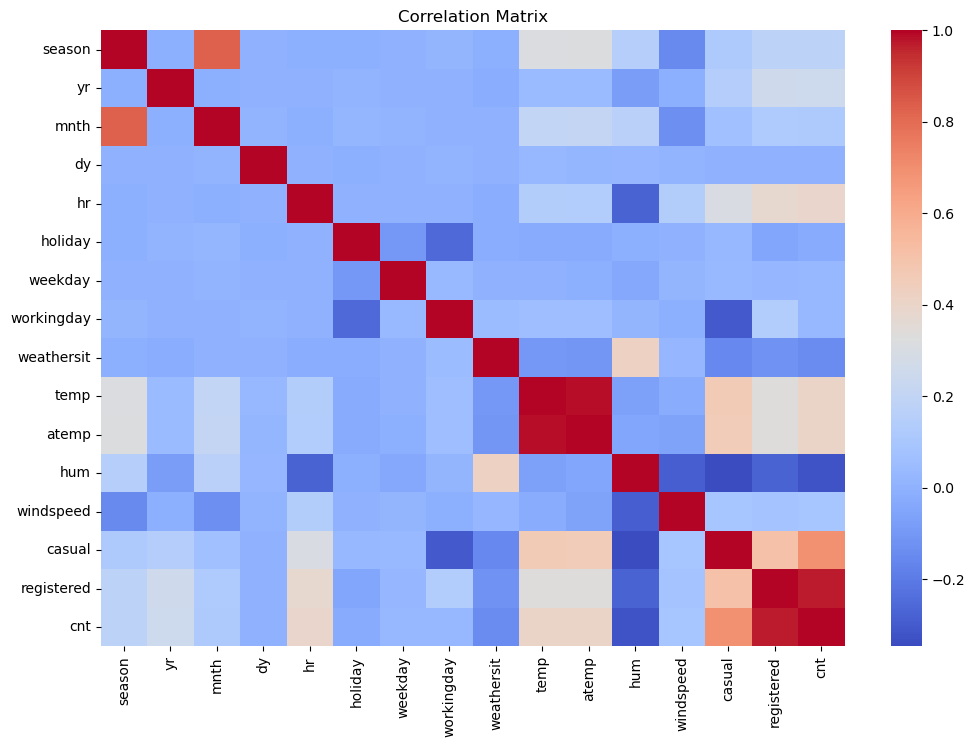

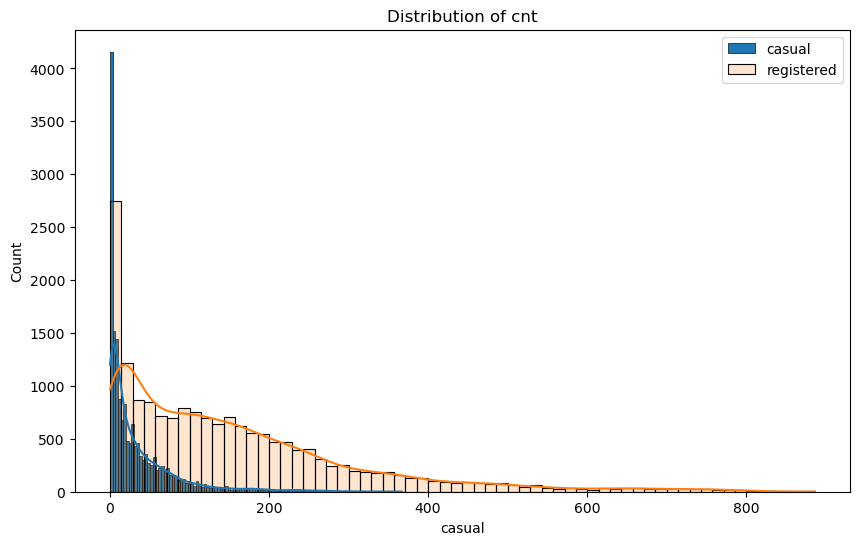

In [ ]:
# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')

# Visualize the distribution of the 'cnt' column
plt.figure(figsize=(10, 6))
sns.histplot(data=bike, x='casual', kde=True, alpha = 1,  label='casual')
sns.histplot(data=bike, x='registered', kde=True, alpha = 0.2,  label='registered')
plt.title('Distribution of cnt')
plt.legend()
plt.show()

There are several findings from these plots:<br>
- Among the time granuality, hour has the highest correlation to cnt column.
- There are different trend between casual users and registered users.  It is recommended to predict them separetly and combine them together to come up with total cnt.

<hr style="border-top: 0.5px solid #b;">
<b style="font-size: 22px;">Task3</b> <h style="font-size: 18px;">  : List the features you would like to use for the model and provide explanations where necessary. </h>
<hr style="border-top: 0.5px solid #b;">

To determine the most effective feature, I first rule out the variables which has less than 0.15 correlation to any of the target column 'cnt', 'casual', or 'regisatered'

In [ ]:
# Identify the most correlated features with 'cnt'
corr_with_cnt = correlation['cnt'].abs().sort_values(ascending=False)

# Select the relevant features based on correlation threshold
threshold = 0.15  
relevant_features = corr_with_cnt[corr_with_cnt > threshold].index.tolist()
print(relevant_features)

['cnt', 'registered', 'casual', 'temp', 'atemp', 'hr', 'hum', 'yr', 'season']


In [ ]:
# Identify the most correlated features with 'casual'
corr_with_cnt = correlation['casual'].abs().sort_values(ascending=False)

# Select the relevant features based on correlation threshold
threshold = 0.15  
relevant_features = corr_with_cnt[corr_with_cnt > threshold].index.tolist()
print(relevant_features)

['casual', 'cnt', 'registered', 'temp', 'atemp', 'hum', 'hr', 'workingday', 'weathersit']


In [ ]:
# Identify the most correlated features with 'registered'
corr_with_cnt = correlation['registered'].abs().sort_values(ascending=False)

# Select the relevant features based on correlation threshold
threshold = 0.15 
relevant_features = corr_with_cnt[corr_with_cnt > threshold].index.tolist()
print(relevant_features)

['registered', 'cnt', 'casual', 'hr', 'temp', 'atemp', 'hum', 'yr', 'season']


It seems ['temp', 'atemp', 'hum', 'hr', 'yr', 'workingday'] are the possible candidates.<br>
Check now for the autocorrelation.

Text(0.5, 1.0, 'Correlation Matrix')

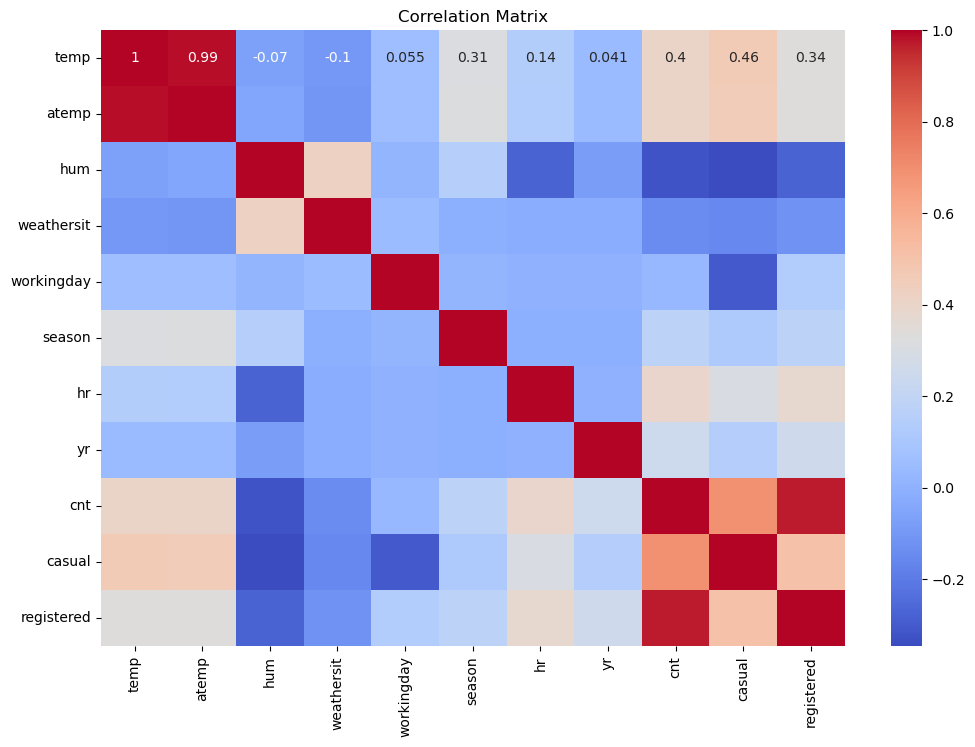

In [ ]:
feature = bike[['temp','atemp','hum','weathersit','workingday','season','hr','yr','cnt','casual','registered']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(feature, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

Given 'temp' and 'atemp' are strongly correlated each other, one of the variables should be dropped.<br>
Provided the correlation value to 'cnt' of both variables are indentical, 'atemp' would be dropped.<br>
<br>
This leaves ['temp', 'hum', 'weathersit', 'workingday', 'season', 'yr', 'hr'] as the potential selected features.<br>
Note the combination among the selected feature changes depending on which dependant variable is being predicted<br>
(further detail as follows) 